In [1]:
import tensorquant as tq
import matplotlib.pyplot as plt
from datetime import date
import pandas as pd

# Market

In [2]:
market_data = {}

ref_date = date(2024, 7, 31)
daycounter_convention = tq.DayCounterConvention.ActualActual
daycounter = tq.DayCounter(daycounter_convention )
calendar = tq.TARGET()

mkt = pd.read_excel("data/market_20240731.xlsx")
mkt['start'] = mkt['start'].dt.date
mkt['end'] = mkt['end'].dt.date
estr_df = mkt[mkt['name'] == 'EUR_ESTR']
eur6m_df = mkt[mkt['name'] == 'EUR_6M']

rates = estr_df['quote'].values/100
times = [daycounter.day_count(ref_date, d) for d in estr_df['end']]

rates_6m = eur6m_df['quote'].values/100
times_6m = [daycounter.day_count(ref_date, d) for d in eur6m_df['end']]
#tq
market_data['EUR:ESTR'] = tq.RateCurve(reference_date=ref_date,
                                    pillars=estr_df['end'],
                                    rates=rates,
                                    interp='LINEAR', 
                                    daycounter_convention=daycounter_convention)
market_data['EUR:6M'] = tq.RateCurve(reference_date=ref_date,
                                    pillars=eur6m_df['end'],
                                    rates=rates_6m,
                                    interp='LINEAR', 
                                    daycounter_convention=daycounter_convention)

# pricing t0

In [3]:
eur6m_index = tq.IborIndex(calendar, 6, tq.TimeUnit.Months, tq.Currency.EUR, 2)
first_fixing = 0.03
eur6m_index.add_fixing(date(2024,7,31), first_fixing)

start_date = date(2024,8,2)
end_date = date(2034,8,2)
fixed_rate = 0.01
notional = 100e6
dc_fix = tq.DayCounter(tq.DayCounterConvention.Actual360)
dc_flt = tq.DayCounter(tq.DayCounterConvention.Actual360)
start_dates_fix = [date(2024, 8, 2),
                date(2025, 8, 4),
                date(2026, 8, 3),
                date(2027, 8, 2),
                date(2028, 8, 2),
                date(2029, 8, 2),
                date(2030, 8, 2),
                date(2031, 8, 4),
                date(2032, 8, 2),
                date(2033, 8, 2)]
end_dates_fix = [date(2025, 8, 4),
                date(2026, 8, 3),
                date(2027, 8, 2),
                date(2028, 8, 2),
                date(2029, 8, 2),
                date(2030, 8, 2),
                date(2031, 8, 4),
                date(2032, 8, 2),
                date(2033, 8, 2),
                date(2034, 8, 2)]
pay_dates_fix = [date(2025, 8, 4),
                date(2026, 8, 3),
                date(2027, 8, 2),
                date(2028, 8, 2),
                date(2029, 8, 2),
                date(2030, 8, 2),
                date(2031, 8, 4),
                date(2032, 8, 2),
                date(2033, 8, 2),
                date(2034, 8, 2)]
start_dates_flt = [date(2024, 8, 2),
                date(2025, 2, 3),
                date(2025, 8, 4),
                date(2026, 2, 2),
                date(2026, 8, 3),
                date(2027, 2, 2),
                date(2027, 8, 2),
                date(2028, 2, 2),
                date(2028, 8, 2),
                date(2029, 2, 2),
                date(2029, 8, 2),
                date(2030, 2, 4),
                date(2030, 8, 2),
                date(2031, 2, 3),
                date(2031, 8, 4),
                date(2032, 2, 2),
                date(2032, 8, 2),
                date(2033, 2, 2),
                date(2033, 8, 2),
                date(2034, 2, 2)]
end_dates_flt = [date(2025, 2, 3),
                date(2025, 8, 4),
                date(2026, 2, 2),
                date(2026, 8, 3),
                date(2027, 2, 2),
                date(2027, 8, 2),
                date(2028, 2, 2),
                date(2028, 8, 2),
                date(2029, 2, 2),
                date(2029, 8, 2),
                date(2030, 2, 4),
                date(2030, 8, 2),
                date(2031, 2, 3),
                date(2031, 8, 4),
                date(2032, 2, 2),
                date(2032, 8, 2),
                date(2033, 2, 2),
                date(2033, 8, 2),
                date(2034, 2, 2),
                date(2034, 8, 2)]
pay_dates_flt = [date(2025, 2, 3),
                date(2025, 8, 4),
                date(2026, 2, 2),
                date(2026, 8, 3),
                date(2027, 2, 2),
                date(2027, 8, 2),
                date(2028, 2, 2),
                date(2028, 8, 2),
                date(2029, 2, 2),
                date(2029, 8, 2),
                date(2030, 2, 4),
                date(2030, 8, 2),
                date(2031, 2, 3),
                date(2031, 8, 4),
                date(2032, 2, 2),
                date(2032, 8, 2),
                date(2033, 2, 2),
                date(2033, 8, 2),
                date(2034, 2, 2),
                date(2034, 8, 2)]
swap = tq.Swap(tq.Currency.EUR,
        start_date, end_date,
        start_dates_fix, end_dates_fix, pay_dates_fix,
        start_dates_flt, end_dates_flt, pay_dates_flt,
        fixed_rate,notional, dc_fix, dc_flt, eur6m_index)

In [4]:
swap_engine = tq.SwapPricer(tq.curve_map)
npv_swap, tape = swap_engine.price(swap, ref_date, market_data, True)
sensitivities = tape.gradient(npv_swap, [market_data['EUR:ESTR']._rates, market_data['EUR:6M']._rates])

print(f"NPV FixedLeg: {swap_engine.pv_fix :,.0f}")
print(f"NPV FloatingLeg: {swap_engine.pv_flt :,.0f}")
########
print(f"NPV Swap: {npv_swap :,.0f}")

NPV FixedLeg: 8,878,379
NPV FloatingLeg: 22,692,468
NPV Swap: 13,814,088


# simulation

In [5]:
# pre-calibrated
a = 0.14
sigma = 0.008

hw_model = tq.HullWhiteProcess(market_data['EUR:ESTR'], a, sigma)

schedule_gen = tq.ScheduleGenerator(calendar, tq.BusinessDayConvention.Unadjusted)
end_date = calendar.advance(ref_date, 30, tq.TimeUnit.Years, tq.BusinessDayConvention.ModifiedFollowing)
dates = schedule_gen.generate(ref_date, end_date, 6, tq.TimeUnit.Months)
date_grid = tq.DateGrid(dates, tq.DayCounterConvention.ActualActual)

n_path = 1000
exp_gen = tq.SwapExposureGenerator(hw_model, date_grid)
exp_gen.simulate(n_path, swap, first_fixing)

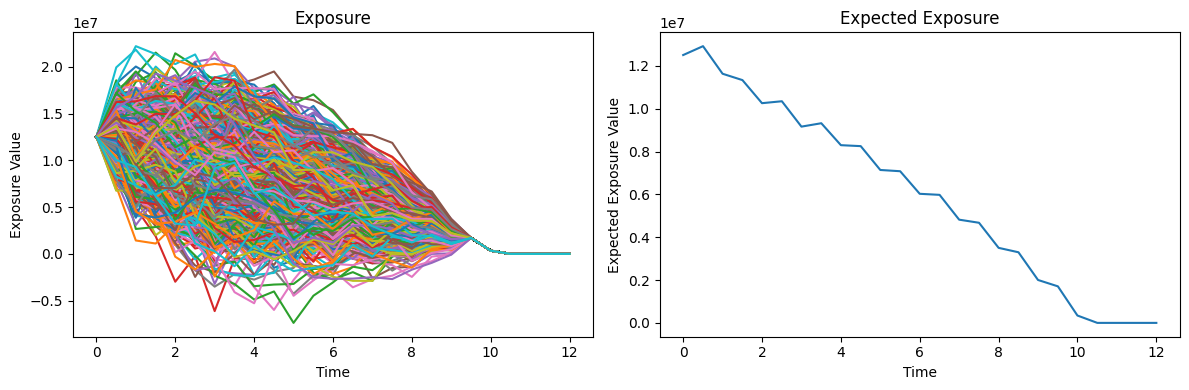

In [6]:
exposure = exp_gen.exposure
ee = exp_gen.expected_exposure

fig, ax = plt.subplots(1, 2, figsize=(12, 4)) 

ax[0].plot(date_grid.times[:25], exposure[:25,:])
ax[0].set_title("Exposure")
ax[0].set_xlabel("Time")
ax[0].set_ylabel("Exposure Value")

ax[1].plot(date_grid.times[:25], ee[:25])
ax[1].set_title("Expected Exposure")
ax[1].set_xlabel("Time")
ax[1].set_ylabel("Expected Exposure Value")

plt.tight_layout()  # Adjust spacing between plots
plt.show()